In [ ]:
!nvidia-smi

Fri Jun  3 11:23:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [ ]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")
aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))

aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [ ]:
# train_test_split
argmax_classes = []
for label in label_df.values:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# len(argmax_classes)
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df.values[train_i]
val_y   = label_df.values[val_i]

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):

    def __init__(self, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        if split.upper() == 'TRAIN':
            self.img_dirs = train_images
            self.y = train_y
        
        if split.upper() == 'VALIDATION':
            self.img_dirs = val_images
            self.y = val_y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        image = Image.open(self.img_dirs[idx])
        image = image.convert('RGB')
        
        y = self.y[idx]

        image = self.transform(image)

        # image = transform2(image, y) # augemnted_label에 속하는 y일 경우 추가적인 augmentation 

        return image, y

import torchvision.transforms as T
!pip install timm -q
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

tf = T.Compose([
    # T.Resize(256, interpolation=3),
    # T.CenterCrop(224),
    T.Resize(224, interpolation=3),
    T.ToTensor(),
    # T.RandomRotation(degrees=(-180, 180)),
    # T.RandomHorizontalFlip(p=0.5),
    # T.RandomVerticalFlip(p=0.5), # Rotation을 넣는 순간 Flip은 한개만 수행하면 되며, H-Flip이 V-Flip보다 빠르다.
    # T.ColorJitter(brightness=.5, contrast=.5),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])


     |████████████████████████████████| 431 kB 5.2 MB/s 


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [ ]:
%cd /content/drive/MyDrive/4-1_Capstone
from class_balanced_loss import CB_loss
from collections import Counter
samples_per_cls = list(map(float, (Counter(sorted(argmax_classes)).values())))
no_of_classes = len(label_df.columns)
loss_type = "focal" # in [sigmoid, softmax, focal]
beta = 0.9999 # usaually in 0.9, 0.99, 0.999, 0.9999
gamma = 2.0

/content/drive/MyDrive/4-1_Capstone


In [ ]:
!pip install timm -q
N_CLASSES = len(label_df.columns)
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    if      optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif    optimizer == 'RMSprop':
        optimizer = torch.optim.RMSProp(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)       

    train_loader = DataLoader(MyDataset(tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        GTs    = []
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            H = model(X)    
            # H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            GTs.extend((Y.detach().cpu().numpy()* 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss = losses / len(GTs)
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, GTs)
        train_macro_f1.append(train_f1)

        # scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                # H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_y)
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_y)
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train-loss": train_loss, "validation-loss": val_loss, "train-f1": train_f1, "val-f1": val_f1})

    # Mark the run as finished
    wandb.finish()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, batch_size = 32):

    test_loader = DataLoader(MyDataset(tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            # H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()


def run(model = 'E', epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, memo=None):

    architecture = 'EfficientNet_B0' if model == 'E' else 'DeiT'
    # 🐝 1️⃣ Start a new run to track this script
    wandb.init(
        # Set the project where this run will be logged
        project="debug",
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name = memo, 
        # Track hyperparameters and run metadata
        config={
        "architecture": architecture,
        "epochs": epoch,
        "optimizer": optimizer,
        "learning_rate": lr,
        })
    
    from torch.nn import Linear
    N_CLASSES = 72
    if model == 'E':
        model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
        model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)

    if model == 'D':
        model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
        model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
    
    train(model, epoch, batch_size, optimizer, lr)
    preds = test(model)

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 50.8 MB/s 
     |████████████████████████████████| 181 kB 54.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1. EfficientNet B0

wandb: Currently logged in as: bjjun970. Use `wandb login --relogin` to force relogin


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  3%|▎         | 1/30 [02:44<1:19:44, 164.97s/it]

EPOCH 0 : TRAIN_LOSS = 0.0007  VAL_LOSS = 0.0003  TRAIN_F1 = 0.604 VAL_F1 = 0.772


  7%|▋         | 2/30 [05:17<1:13:39, 157.83s/it]

EPOCH 1 : TRAIN_LOSS = 0.0003  VAL_LOSS = 0.0002  TRAIN_F1 = 0.800 VAL_F1 = 0.807


 10%|█         | 3/30 [07:49<1:09:49, 155.15s/it]

EPOCH 2 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0003  TRAIN_F1 = 0.839 VAL_F1 = 0.825


 13%|█▎        | 4/30 [10:27<1:07:42, 156.25s/it]

EPOCH 3 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.860 VAL_F1 = 0.833


 17%|█▋        | 5/30 [13:05<1:05:19, 156.76s/it]

EPOCH 4 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.876 VAL_F1 = 0.831


 20%|██        | 6/30 [15:42<1:02:49, 157.05s/it]

EPOCH 5 : TRAIN_LOSS = 0.0002  VAL_LOSS = 0.0002  TRAIN_F1 = 0.888 VAL_F1 = 0.855


 23%|██▎       | 7/30 [18:21<1:00:21, 157.44s/it]

EPOCH 6 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.897 VAL_F1 = 0.856


 27%|██▋       | 8/30 [21:09<59:00, 160.95s/it]  

EPOCH 7 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.914 VAL_F1 = 0.846


 30%|███       | 9/30 [23:54<56:45, 162.18s/it]

EPOCH 8 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.917 VAL_F1 = 0.882


 33%|███▎      | 10/30 [26:35<53:54, 161.70s/it]

EPOCH 9 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.929 VAL_F1 = 0.871


 37%|███▋      | 11/30 [29:19<51:27, 162.52s/it]

EPOCH 10 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0002  TRAIN_F1 = 0.936 VAL_F1 = 0.864


 40%|████      | 12/30 [32:05<49:03, 163.51s/it]

EPOCH 11 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.942 VAL_F1 = 0.856


 43%|████▎     | 13/30 [34:48<46:16, 163.35s/it]

EPOCH 12 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.951 VAL_F1 = 0.854


 47%|████▋     | 14/30 [37:30<43:27, 162.97s/it]

EPOCH 13 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.952 VAL_F1 = 0.862


 50%|█████     | 15/30 [40:13<40:47, 163.16s/it]

EPOCH 14 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.956 VAL_F1 = 0.873


 53%|█████▎    | 16/30 [42:57<38:06, 163.32s/it]

EPOCH 15 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.961 VAL_F1 = 0.872


 57%|█████▋    | 17/30 [45:42<35:30, 163.86s/it]

EPOCH 16 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.961 VAL_F1 = 0.879


 60%|██████    | 18/30 [48:31<33:01, 165.16s/it]

EPOCH 17 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.966 VAL_F1 = 0.869


 63%|██████▎   | 19/30 [51:13<30:08, 164.37s/it]

EPOCH 18 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.967 VAL_F1 = 0.875


 67%|██████▋   | 20/30 [53:56<27:18, 163.81s/it]

EPOCH 19 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.968 VAL_F1 = 0.875


 70%|███████   | 21/30 [56:37<24:27, 163.01s/it]

EPOCH 20 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.968 VAL_F1 = 0.869


 73%|███████▎  | 22/30 [59:18<21:41, 162.65s/it]

EPOCH 21 : TRAIN_LOSS = 0.0001  VAL_LOSS = 0.0003  TRAIN_F1 = 0.970 VAL_F1 = 0.866


 77%|███████▋  | 23/30 [1:02:01<18:58, 162.67s/it]

EPOCH 22 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.974 VAL_F1 = 0.876


 80%|████████  | 24/30 [1:04:38<16:05, 160.94s/it]

EPOCH 23 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.975 VAL_F1 = 0.868


 83%|████████▎ | 25/30 [1:07:11<13:12, 158.57s/it]

EPOCH 24 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.975 VAL_F1 = 0.866


 87%|████████▋ | 26/30 [1:09:46<10:30, 157.60s/it]

EPOCH 25 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.974 VAL_F1 = 0.859


 90%|█████████ | 27/30 [1:12:22<07:50, 156.87s/it]

EPOCH 26 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.977 VAL_F1 = 0.875


 93%|█████████▎| 28/30 [1:15:02<05:15, 157.77s/it]

EPOCH 27 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.977 VAL_F1 = 0.870


 97%|█████████▋| 29/30 [1:17:37<02:36, 156.93s/it]

EPOCH 28 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.977 VAL_F1 = 0.877


100%|██████████| 30/30 [1:20:12<00:00, 160.40s/it]

EPOCH 29 : TRAIN_LOSS = 0.0000  VAL_LOSS = 0.0003  TRAIN_F1 = 0.977 VAL_F1 = 0.874


train-f1,▁▅▅▆▆▆▇▇▇▇▇▇██████████████████
train-loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val-f1,▁▃▄▅▅▆▆▆█▇▇▆▆▇▇▇█▇██▇▇█▇▇▇█▇█▇
validation-loss,▇▃▄▂▂▂▃▄▁▂▃▇▅▅▄▅▄▆▅▅▅▅▆▇▇█▇█▆▇
train-f1,0.97674
train-loss,4e-05
val-f1,0.87428
validation-loss,0.00032


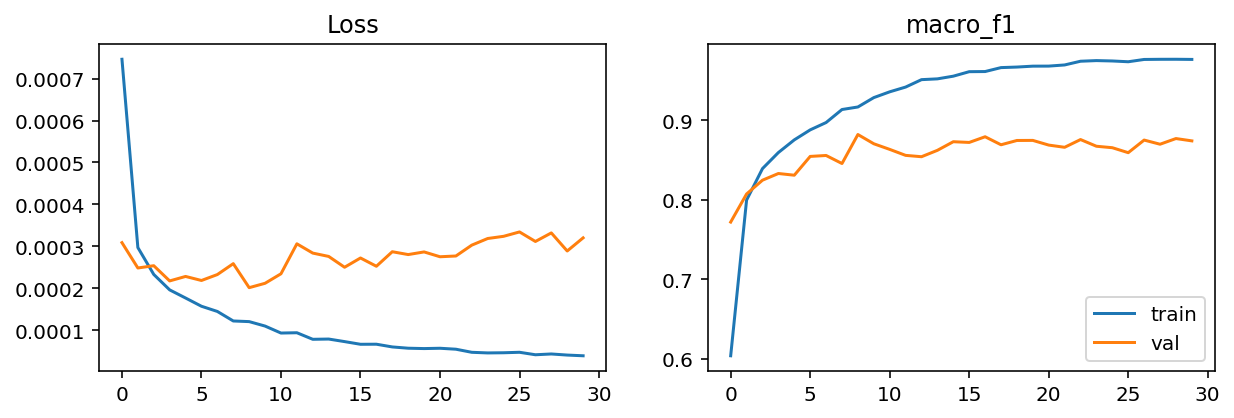

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      0.98      0.99       139
           2       0.97      1.00      0.99       311
           3       0.98      0.93      0.95       727
           4       0.81      0.80      0.81        65
           5       0.99      1.00      0.99       420
           6       0.96      0.99      0.98       273
           7       0.97      0.94      0.96       299
           8       0.98      0.99      0.99       413
           9       1.00      1.00      1.00       361
          10       0.99      0.99      0.99       142
          11       0.99      0.96      0.97       283
          12       0.87      0.98      0.92       125
          13       0.68      0.78      0.72        81
          14       0.87      0.75      0.81       125
          15       0.97      0.98      0.98       125
          16       0.97      0.90      0.93       125
          17       0.96    

In [ ]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='Adam', memo = "BaseLine 30")

# 2.DeiT

In [ ]:
run(model = 'D', epoch= 10, batch_size = 32, optimizer='Adam', memo = "BaseLine")

In [ ]:
run(model = 'D', epoch= 10, batch_size = 32, optimizer='AdamW', memo = "Scheduler")